### Классификация Симпсонов

на колабе закончился гпу, перешел на свой

In [1]:
#!nvidia-smi
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [11]:
import PIL
print(PIL.__version__)

8.2.0


In [2]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline


import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

распаковал в корень во временные файлы, иначе обучение не идет на колабе



In [3]:
TEST_DIR = Path('C:/Users/Vladimir/Documents/Py_works/Deep learning course/DL advanced course/journey-springfield/testset')
TRAIN_DIR = Path('C:/Users/Vladimir/Documents/Py_works/Deep learning course/DL advanced course/journey-springfield/train')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [4]:
#train_val_files[0]
test_files[0]

WindowsPath('C:/Users/Vladimir/Documents/Py_works/Deep learning course/DL advanced course/journey-springfield/testset/testset/img0.jpg')

In [5]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [6]:
#train_val_labels[0]
val_files[0]
#train_files[0]

WindowsPath('C:/Users/Vladimir/Documents/Py_works/Deep learning course/DL advanced course/journey-springfield/train/simpsons_dataset/lisa_simpson/pic_1107.jpg')

In [7]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

обработка картинки, плюс метки

In [82]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [23]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [83]:
val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [85]:
val_dataset[0][0].size()

torch.Size([3, 224, 224])

In [86]:
train_dataset[0][0].size()

torch.Size([3, 224, 224])

картинки

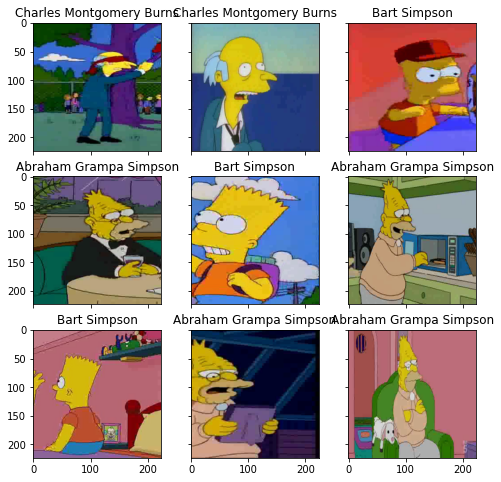

In [25]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Простая сетка
1. размерность входа: 3x224x224 
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5

In [27]:
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [8]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [9]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [30]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_files, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_files, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

немного поменяем

In [11]:
def trainA(train_files, val_files, model, epochs, batch_size, optimizer, criterion):
    
    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    train_loader = DataLoader(train_files, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_files, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = optimizer
        criterion = criterion

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
            # если достиглось лучшее качество, то запомним веса модели
            if val_acc > best_acc:
                best_acc = val_acc
                best_model_wts = model.state_dict()
                
        # загрузим лучшие веса модели
    model.load_state_dict(best_model_wts)
    print('Best val Acc: {:4f}'.format(best_acc))
            
    return history, model

In [47]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [32]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2400, out_fea

поехали

In [33]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=2, batch_size=64)

epoch:   0%|                                                                                | 0/2 [00:00<?, ?it/s]

loss 2.5948293194648406


epoch:  50%|███████████████████████████████████▌                                   | 1/2 [04:09<04:09, 249.95s/it]


Epoch 001 train_loss: 2.5948     val_loss 1.9736 train_acc 0.2793 val_acc 0.4620
loss 1.5471884137513918


epoch: 100%|███████████████████████████████████████████████████████████████████████| 2/2 [06:48<00:00, 204.23s/it]


Epoch 002 train_loss: 1.5472     val_loss 1.4026 train_acc 0.5776 val_acc 0.6190


график

In [34]:
loss, acc, val_loss, val_acc = zip(*history)

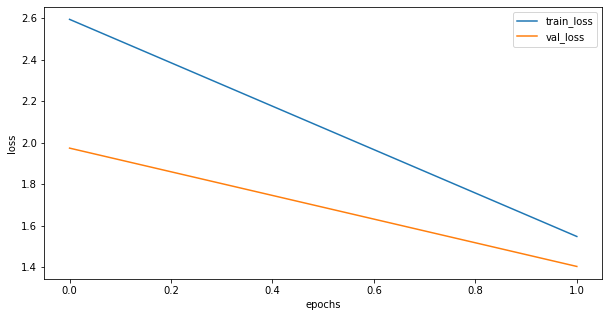

In [35]:
plt.figure(figsize=(10, 5))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

предиктим один

In [36]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [37]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [38]:
# распр-е по классам
probs_im

array([[5.46285734e-02, 8.36545601e-04, 5.32187754e-03, 6.11426076e-04,
        1.17919799e-02, 1.01898322e-02, 2.23797560e-01, 2.08671521e-02,
        3.65352235e-03, 1.08660860e-02, 1.52650373e-05, 6.06078608e-03,
        9.26565644e-06, 8.18409462e-05, 1.08141941e-03, 9.16573182e-02,
        4.96347842e-04, 3.57754226e-03, 6.16925536e-03, 1.98202747e-06,
        9.30554699e-03, 1.22036133e-03, 1.87565247e-03, 5.72878867e-03,
        1.49675474e-01, 2.79325899e-03, 1.22795376e-04, 4.01267260e-02,
        1.21614514e-02, 1.04616145e-02, 5.05315074e-05, 3.43074760e-04,
        2.92268276e-01, 6.04427373e-03, 1.22641475e-04, 9.11952287e-04,
        7.86782766e-05, 8.72713514e-03, 6.41820588e-06, 4.80494043e-03,
        9.09080597e-07, 1.45394099e-03]], dtype=float32)

несколько

In [39]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [40]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [41]:
label_encoder.classes_

array(['abraham_grampa_simpson', 'agnes_skinner',
       'apu_nahasapeemapetilon', 'barney_gumble', 'bart_simpson',
       'carl_carlson', 'charles_montgomery_burns', 'chief_wiggum',
       'cletus_spuckler', 'comic_book_guy', 'disco_stu', 'edna_krabappel',
       'fat_tony', 'gil', 'groundskeeper_willie', 'homer_simpson',
       'kent_brockman', 'krusty_the_clown', 'lenny_leonard',
       'lionel_hutz', 'lisa_simpson', 'maggie_simpson', 'marge_simpson',
       'martin_prince', 'mayor_quimby', 'milhouse_van_houten',
       'miss_hoover', 'moe_szyslak', 'ned_flanders', 'nelson_muntz',
       'otto_mann', 'patty_bouvier', 'principal_skinner',
       'professor_john_frink', 'rainier_wolfcastle', 'ralph_wiggum',
       'selma_bouvier', 'sideshow_bob', 'sideshow_mel', 'snake_jailbird',
       'troy_mcclure', 'waylon_smithers'], dtype='<U24')

In [42]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [43]:
print(y_pred)
print(actual_labels)

[ 2  2  4  3 17  6  2  6  4  7  6  0  0  4  4  2  4  4 15 20]
[2, 2, 4, 3, 0, 6, 2, 6, 4, 6, 3, 0, 0, 4, 4, 2, 4, 4, 0, 4]


In [44]:
from sklearn.metrics import f1_score

f1_score(actual_labels, y_pred, average ='weighted')

0.823076923076923

#### визуализация

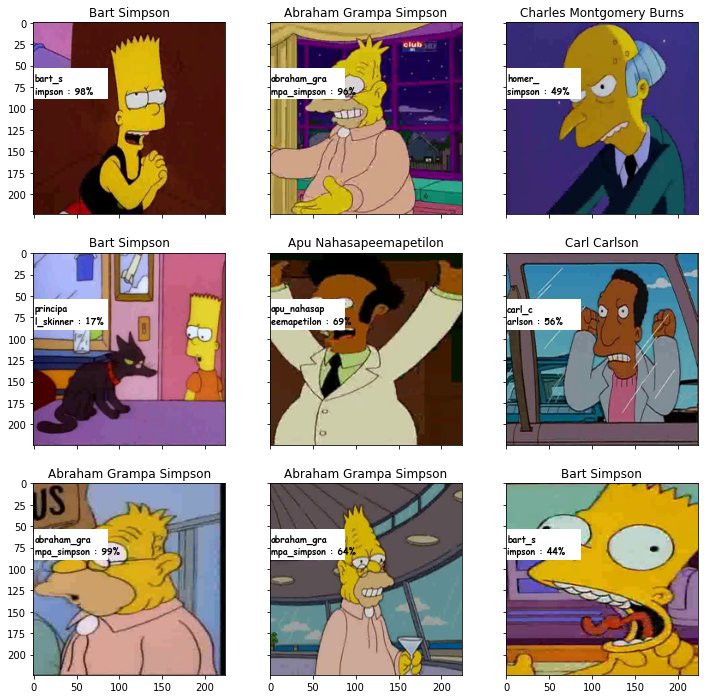

In [45]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=9, color='black',fontweight='bold')

сабмит

In [46]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [47]:
!ls

8. PyTorch, basic NN
Competition
Competition_2
Metrics.pdf
Springfield.ipynb
Week_1
desktop.ini
journey-springfield
journey-springfield.zip
label_encoder.pkl
РћРїС‚РёРјРёР·Р°С†РёСЏ Рё СЂРµРіСѓР»СЏСЂРёР·Р°С†РёСЏ РІ Deep Learning.pdf
РџРѕРґРєР»СЋС‡Р°РµРј google drive Рє google colab.docx


In [49]:
import pandas as pd
#my_submit = pd.read_csv("gdrive/My Drive/simpsons/data/labels.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [50]:
my_submit.to_csv('simple_cnn_baseline.csv', index=False)

#### посмотрим как предсказывались классы

In [72]:
imgs = [val_dataset[id][0].unsqueeze(0) for id in range(len(val_dataset))]

actual_labels = [val_dataset[id][1] for id in range(len(val_dataset))]

probs_ims = predict(simple_cnn, imgs)
y_pred = np.argmax(probs_ims,-1)

In [59]:
preds_class = [label_encoder.classes_[i] for i in y_pred]

In [74]:
from sklearn.metrics import classification_report


print(classification_report(actual_labels, y_pred, target_names=label_encoder.classes_))

                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.48      0.71      0.57       228
           agnes_skinner       0.00      0.00      0.00        10
  apu_nahasapeemapetilon       0.56      0.87      0.68       156
           barney_gumble       0.71      0.19      0.30        26
            bart_simpson       0.55      0.51      0.53       336
            carl_carlson       0.34      0.42      0.38        24
charles_montgomery_burns       0.64      0.51      0.57       298
            chief_wiggum       0.94      0.53      0.68       247
         cletus_spuckler       0.00      0.00      0.00        12
          comic_book_guy       0.76      0.44      0.56       117
               disco_stu       0.00      0.00      0.00         2
          edna_krabappel       0.53      0.70      0.60       114
                fat_tony       0.00      0.00      0.00         7
                     gil       0.00      0.00      0.00         7
    groun

C:\Users\Vladimir\anaconda3\envs\CUDA_GPU\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Vladimir\anaconda3\envs\CUDA_GPU\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Vladimir\anaconda3\envs\CUDA_GPU\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Попробуем тюнить другие архитектуры

In [10]:
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import numpy as np
from tqdm import tqdm, trange

### AlexNet

In [30]:
modelA = models.alexnet(pretrained=True)
modelA

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

файнтюнинг

In [31]:
num_features = 9216
# 42 класса
modelA.classifier = nn.Linear(num_features, 42)
modelA = modelA.cuda()

# cost function
loss_fn = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model.parameters(), lr=1e-4)

# эвристика
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
train_dataset, val_dataset

In [27]:
len(val_dataset)

5234

In [46]:
epochs = 5
batch_size=256
historyA, modelA = trainA(train_dataset, val_dataset, modelA, epochs, batch_size,optimizer_ft, loss_fn )

epoch:   0%|                                                                                | 0/5 [00:00<?, ?it/s]

loss 4.576114256189571


epoch:  20%|██████████████▏                                                        | 1/5 [02:42<10:48, 162.05s/it]


Epoch 001 train_loss: 4.5761     val_loss 4.5623 train_acc 0.0124 val_acc 0.0149
loss 4.576114279334352


epoch:  40%|████████████████████████████▍                                          | 2/5 [05:25<08:07, 162.63s/it]


Epoch 002 train_loss: 4.5761     val_loss 4.5623 train_acc 0.0124 val_acc 0.0149
loss 4.576114295007195


epoch:  60%|██████████████████████████████████████████▌                            | 3/5 [08:09<05:26, 163.41s/it]


Epoch 003 train_loss: 4.5761     val_loss 4.5623 train_acc 0.0124 val_acc 0.0149
loss 4.576114312836574


epoch:  80%|████████████████████████████████████████████████████████▊              | 4/5 [11:02<02:47, 167.04s/it]


Epoch 004 train_loss: 4.5761     val_loss 4.5623 train_acc 0.0124 val_acc 0.0149
loss 4.576114164248295


epoch: 100%|███████████████████████████████████████████████████████████████████████| 5/5 [13:55<00:00, 167.02s/it]


Epoch 005 train_loss: 4.5761     val_loss 4.5623 train_acc 0.0124 val_acc 0.0149
Best val Acc: 0.014903


С нуля обучать тяжело

обучаем только классификатор из Алекснета

In [48]:
model_extractorA = models.alexnet(pretrained=True)

In [49]:
# замораживаем параметры (веса)
for param in model_extractorA.parameters():
    param.requires_grad = False

num_features = 9216

model_extractorA.classifier = nn.Linear(num_features, 42)

model_extractorA = model_extractorA.cuda()

# cost function
loss_fn = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(model_extractorA.classifier.parameters(), lr=1e-4)

# эвристика
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [50]:
%%time
epochs = 10
batch_size=256

historyA2, model_extractorA = trainA(train_dataset, val_dataset, model_extractorA, epochs, batch_size,optimizer_ft, loss_fn )


epoch:   0%|                                                                               | 0/10 [00:00<?, ?it/s]

loss 2.284700625959844


epoch:  10%|███████                                                               | 1/10 [03:44<33:36, 224.04s/it]


Epoch 001 train_loss: 2.2847     val_loss 1.5025 train_acc 0.4052 val_acc 0.6240
loss 1.0936369485623958


epoch:  20%|██████████████                                                        | 2/10 [06:19<24:30, 183.83s/it]


Epoch 002 train_loss: 1.0936     val_loss 1.1167 train_acc 0.7309 val_acc 0.7186
loss 0.7510490442424893


epoch:  30%|█████████████████████                                                 | 3/10 [08:53<19:51, 170.17s/it]


Epoch 003 train_loss: 0.7510     val_loss 0.9541 train_acc 0.8195 val_acc 0.7503
loss 0.5697377989782528


epoch:  40%|████████████████████████████                                          | 4/10 [11:27<16:21, 163.66s/it]


Epoch 004 train_loss: 0.5697     val_loss 0.8700 train_acc 0.8716 val_acc 0.7746
loss 0.4517789986856622


epoch:  50%|███████████████████████████████████                                   | 5/10 [14:03<13:24, 160.94s/it]


Epoch 005 train_loss: 0.4518     val_loss 0.8126 train_acc 0.9058 val_acc 0.7896
loss 0.3707522863631446


epoch:  60%|██████████████████████████████████████████                            | 6/10 [16:40<10:38, 159.74s/it]


Epoch 006 train_loss: 0.3708     val_loss 0.7851 train_acc 0.9300 val_acc 0.7935
loss 0.30764641418233935


epoch:  70%|█████████████████████████████████████████████████                     | 7/10 [19:19<07:58, 159.53s/it]


Epoch 007 train_loss: 0.3076     val_loss 0.7560 train_acc 0.9460 val_acc 0.8040
loss 0.26037933185712736


epoch:  80%|████████████████████████████████████████████████████████              | 8/10 [21:57<05:18, 159.05s/it]


Epoch 008 train_loss: 0.2604     val_loss 0.7417 train_acc 0.9583 val_acc 0.8086
loss 0.22286010261773836


epoch:  90%|███████████████████████████████████████████████████████████████       | 9/10 [24:38<02:39, 159.65s/it]


Epoch 009 train_loss: 0.2229     val_loss 0.7231 train_acc 0.9683 val_acc 0.8139
loss 0.19257168177662629


epoch: 100%|█████████████████████████████████████████████████████████████████████| 10/10 [27:15<00:00, 163.52s/it]


Epoch 010 train_loss: 0.1926     val_loss 0.7163 train_acc 0.9770 val_acc 0.8160
Best val Acc: 0.816011
Wall time: 27min 15s


In [51]:
torch.save(model_extractorA.state_dict(), 'AlexNet_extractor.pth')

In [55]:
imgs = [val_dataset[id][0].unsqueeze(0) for id in range(len(val_dataset))]

actual_labels = [val_dataset[id][1] for id in range(len(val_dataset))]

probs_ims = predict(model_extractorA, imgs)
y_pred = np.argmax(probs_ims,-1)

In [58]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [63]:
print(classification_report(actual_labels, y_pred, target_names=label_encoder.classes_))

                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.84      0.81      0.83       228
           agnes_skinner       1.00      0.20      0.33        10
  apu_nahasapeemapetilon       0.89      0.93      0.91       156
           barney_gumble       0.75      0.35      0.47        26
            bart_simpson       0.73      0.86      0.79       336
            carl_carlson       1.00      0.54      0.70        24
charles_montgomery_burns       0.83      0.76      0.80       298
            chief_wiggum       0.88      0.89      0.88       247
         cletus_spuckler       1.00      0.67      0.80        12
          comic_book_guy       0.97      0.83      0.89       117
               disco_stu       1.00      0.50      0.67         2
          edna_krabappel       0.86      0.82      0.84       114
                fat_tony       1.00      0.71      0.83         7
                     gil       1.00      0.29      0.44         7
    groun

C:\Users\Vladimir\anaconda3\envs\CUDA_GPU\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Vladimir\anaconda3\envs\CUDA_GPU\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Vladimir\anaconda3\envs\CUDA_GPU\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [64]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model_extractorA, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [65]:
import pandas as pd
#my_submit = pd.read_csv("gdrive/My Drive/simpsons/data/labels.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [66]:
my_submit.to_csv('model_extractorAlex.csv', index=False)

### Добавим аугментацию и постоянные метки

In [62]:
class SimpsonsDataset2(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]

                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform_a = transforms.Compose([
            #transforms.RandomVerticalFlip(),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.Resize(size=(224, 224)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        transform = transforms.Compose([
            #transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        
        x = self.load_sample(self.files[index])


        if self.mode =='test':
            x = self._prepare_sample(x)
            x = transform(x)
            return x
        elif self.mode == 'val':
            x = self._prepare_sample(x)
            x = transform(x)
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        else:
            x = transform_a(x)
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((224, 224))
        return np.array(image)

In [63]:
val_dataset2 = SimpsonsDataset2(val_files, mode='val')
    
train_dataset2 = SimpsonsDataset2(train_files, mode='train')

In [64]:
print(val_dataset2[15][0].size())
train_dataset2[20][0].size()

torch.Size([3, 224, 224])


torch.Size([3, 224, 224])

### Дообучим Алекснэт

In [13]:
model_Alex = models.alexnet(pretrained=True)

In [15]:
num_features = 9216
model_Alex.classifier = nn.Linear(num_features, 42)

In [16]:
model_Alex.load_state_dict(torch.load('AlexNet_extractor.pth'))
model_Alex

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Linear(in_features=9216, out_features=42, bias=True)
)

In [33]:
layers_to_unfreeze = 2

for param in model_Alex.features[:-layers_to_unfreeze].parameters():
    param.requires_grad = False

model_Alex = model_Alex.cuda()

loss_fn = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(list(model_Alex.features.parameters())[-layers_to_unfreeze:] +
                          list(model_Alex.classifier.parameters()), lr=1e-4)

In [34]:
model_Alex

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Linear(in_features=9216, out_features=42, bias=True)
)

In [61]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [42]:
%%time
epochs = 20
batch_size=64

historyA, model_Alex = trainA(train_dataset2, val_dataset2, model_Alex, epochs, batch_size, optimizer_ft, loss_fn )

torch.save(model_Alex.state_dict(), 'model_Alex_2.pth')

epoch:   0%|                                                                               | 0/20 [00:00<?, ?it/s]

loss 1.45083098735344


epoch:   5%|███▌                                                                  | 1/20 [02:39<50:36, 159.80s/it]


Epoch 001 train_loss: 1.4508     val_loss 0.4676 train_acc 0.6232 val_acc 0.8911
loss 0.9515441110144908


epoch:  10%|███████                                                               | 2/20 [05:18<47:42, 159.04s/it]


Epoch 002 train_loss: 0.9515     val_loss 0.5154 train_acc 0.7437 val_acc 0.8693
loss 0.8082841856402647


epoch:  15%|██████████▌                                                           | 3/20 [07:57<45:01, 158.92s/it]


Epoch 003 train_loss: 0.8083     val_loss 0.5520 train_acc 0.7857 val_acc 0.8479
loss 0.7061131612283651


epoch:  20%|██████████████                                                        | 4/20 [10:35<42:19, 158.73s/it]


Epoch 004 train_loss: 0.7061     val_loss 0.5699 train_acc 0.8137 val_acc 0.8401
loss 0.6447638757054658


epoch:  25%|█████████████████▌                                                    | 5/20 [13:11<39:28, 157.89s/it]


Epoch 005 train_loss: 0.6448     val_loss 0.5805 train_acc 0.8301 val_acc 0.8303
loss 0.5926030484215683


epoch:  30%|█████████████████████                                                 | 6/20 [15:50<36:51, 158.00s/it]


Epoch 006 train_loss: 0.5926     val_loss 0.5902 train_acc 0.8429 val_acc 0.8342
loss 0.5436757217452696


epoch:  35%|████████████████████████▌                                             | 7/20 [18:26<34:07, 157.47s/it]


Epoch 007 train_loss: 0.5437     val_loss 0.5936 train_acc 0.8539 val_acc 0.8309
loss 0.5078695944307928


epoch:  40%|████████████████████████████                                          | 8/20 [21:02<31:24, 157.06s/it]


Epoch 008 train_loss: 0.5079     val_loss 0.6148 train_acc 0.8697 val_acc 0.8277
loss 0.46600479188068056


epoch:  45%|███████████████████████████████▌                                      | 9/20 [23:39<28:45, 156.89s/it]


Epoch 009 train_loss: 0.4660     val_loss 0.6173 train_acc 0.8776 val_acc 0.8250
loss 0.44418252920738427


epoch:  50%|██████████████████████████████████▌                                  | 10/20 [26:16<26:08, 156.87s/it]


Epoch 010 train_loss: 0.4442     val_loss 0.6264 train_acc 0.8841 val_acc 0.8237
loss 0.41459919187178074


epoch:  55%|█████████████████████████████████████▉                               | 11/20 [28:52<23:31, 156.87s/it]


Epoch 011 train_loss: 0.4146     val_loss 0.6314 train_acc 0.8931 val_acc 0.8212
loss 0.3898386112750962


epoch:  60%|█████████████████████████████████████████▍                           | 12/20 [31:28<20:53, 156.63s/it]


Epoch 012 train_loss: 0.3898     val_loss 0.6307 train_acc 0.9020 val_acc 0.8233
loss 0.36843006743299817


epoch:  65%|████████████████████████████████████████████▊                        | 13/20 [34:03<18:11, 155.99s/it]


Epoch 013 train_loss: 0.3684     val_loss 0.6478 train_acc 0.9060 val_acc 0.8179
loss 0.34678602517998985


epoch:  70%|████████████████████████████████████████████████▎                    | 14/20 [36:40<15:37, 156.29s/it]


Epoch 014 train_loss: 0.3468     val_loss 0.6479 train_acc 0.9139 val_acc 0.8172
loss 0.3342913865608367


epoch:  75%|███████████████████████████████████████████████████▊                 | 15/20 [39:16<13:00, 156.19s/it]


Epoch 015 train_loss: 0.3343     val_loss 0.6634 train_acc 0.9188 val_acc 0.8137
loss 0.3178379115910126


epoch:  80%|███████████████████████████████████████████████████████▏             | 16/20 [41:52<10:24, 156.13s/it]


Epoch 016 train_loss: 0.3178     val_loss 0.6661 train_acc 0.9198 val_acc 0.8164
loss 0.30346864532897394


epoch:  85%|██████████████████████████████████████████████████████████▋          | 17/20 [44:28<07:48, 156.10s/it]


Epoch 017 train_loss: 0.3035     val_loss 0.6853 train_acc 0.9255 val_acc 0.8118
loss 0.2879773831757036


epoch:  90%|██████████████████████████████████████████████████████████████       | 18/20 [47:05<05:12, 156.31s/it]


Epoch 018 train_loss: 0.2880     val_loss 0.6847 train_acc 0.9301 val_acc 0.8074
loss 0.2755454299430785


epoch:  95%|█████████████████████████████████████████████████████████████████▌   | 19/20 [49:16<02:28, 148.71s/it]


Epoch 019 train_loss: 0.2755     val_loss 0.6820 train_acc 0.9327 val_acc 0.8147
loss 0.2593568764981498


epoch: 100%|█████████████████████████████████████████████████████████████████████| 20/20 [51:21<00:00, 154.06s/it]


Epoch 020 train_loss: 0.2594     val_loss 0.7103 train_acc 0.9381 val_acc 0.8023
Best val Acc: 0.891097
Wall time: 51min 21s


In [44]:
loss, acc, val_loss, val_acc = zip(*historyA)

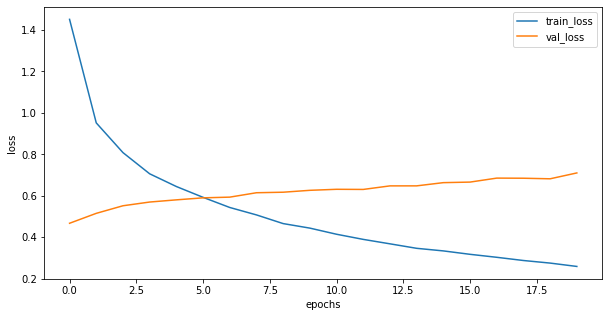

In [45]:
plt.figure(figsize=(10, 5))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [48]:
imgs = [val_dataset2[id][0].unsqueeze(0) for id in range(len(val_dataset2))]

actual_labels = [val_dataset2[id][1] for id in range(len(val_dataset2))]

probs_ims = predict(model_Alex, imgs)
y_pred = np.argmax(probs_ims,-1)

In [51]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

print(classification_report(actual_labels, y_pred, target_names=label_encoder.classes_))

                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.83      0.76      0.79       228
           agnes_skinner       1.00      0.20      0.33        10
  apu_nahasapeemapetilon       0.95      0.94      0.94       156
           barney_gumble       0.71      0.65      0.68        26
            bart_simpson       0.83      0.75      0.79       336
            carl_carlson       0.95      0.88      0.91        24
charles_montgomery_burns       0.71      0.81      0.76       298
            chief_wiggum       0.87      0.80      0.83       247
         cletus_spuckler       1.00      0.67      0.80        12
          comic_book_guy       0.85      0.86      0.86       117
               disco_stu       1.00      0.50      0.67         2
          edna_krabappel       0.90      0.72      0.80       114
                fat_tony       1.00      0.57      0.73         7
                     gil       1.00      0.57      0.73         7
    groun

C:\Users\Vladimir\anaconda3\envs\CUDA_GPU\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Vladimir\anaconda3\envs\CUDA_GPU\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Vladimir\anaconda3\envs\CUDA_GPU\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Поменял аугментацию, обучать будем меньше слоев

In [57]:
model_Alex2 = models.alexnet(pretrained=True)

In [58]:
num_features = 9216
model_Alex2.classifier = nn.Linear(num_features, 42)

In [59]:
model_Alex2.load_state_dict(torch.load('AlexNet_extractor.pth'))
model_Alex2

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Linear(in_features=9216, out_features=42, bias=True)
)

In [60]:
layers_to_unfreeze = 1

for param in model_Alex2.features[:-layers_to_unfreeze].parameters():
    param.requires_grad = False

model_Alex2 = model_Alex2.cuda()

loss_fn = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(list(model_Alex2.features.parameters())[-layers_to_unfreeze:] +
                          list(model_Alex2.classifier.parameters()), lr=1e-4)

In [ ]:
%%time
epochs = 10
batch_size=128

historyA2, model_Alex2 = trainA(train_dataset2, val_dataset2, model_Alex2, epochs, batch_size, optimizer_ft, loss_fn )

torch.save(model_Alex.state_dict(), 'model_Alex_3.pth')

epoch:   0%|                                                                               | 0/10 [00:00<?, ?it/s]

loss 0.7061963418508246


epoch:  10%|███████                                                               | 1/10 [02:22<21:25, 142.88s/it]


Epoch 001 train_loss: 0.7062     val_loss 0.3340 train_acc 0.8166 val_acc 0.9303
loss 0.5736781811211488


epoch:  20%|██████████████                                                        | 2/10 [04:48<19:18, 144.76s/it]


Epoch 002 train_loss: 0.5737     val_loss 0.3451 train_acc 0.8465 val_acc 0.9220
loss 0.5141540901418993


epoch:  30%|█████████████████████                                                 | 3/10 [07:17<17:04, 146.40s/it]


Epoch 003 train_loss: 0.5142     val_loss 0.3455 train_acc 0.8585 val_acc 0.9178
loss 0.46130504657473637


epoch:  40%|████████████████████████████                                          | 4/10 [09:53<15:00, 150.10s/it]


Epoch 004 train_loss: 0.4613     val_loss 0.3466 train_acc 0.8736 val_acc 0.9157
loss 0.4214049612263128


epoch:  50%|███████████████████████████████████                                   | 5/10 [12:24<12:32, 150.45s/it]


Epoch 005 train_loss: 0.4214     val_loss 0.3568 train_acc 0.8864 val_acc 0.9089


### VGG11

In [14]:
model_vgg11 = models.vgg11_bn(pretrained=True)
model_vgg11

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [203]:
# замораживаем
for param in model_vgg11.parameters():
    param.requires_grad = False

num_features = 4096

model_vgg11.classifier[6] = nn.Linear(num_features, 42)

model_vgg11 = model_vgg11.cuda()

# cost function
loss_fn = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_vgg11.classifier.parameters(), lr=0.001, momentum=0.9)

In [219]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [205]:
%%time
epochs = 10
batch_size=128

history11, model_vgg11 = trainA(train_dataset2, val_dataset2, model_vgg11, epochs, batch_size, optimizer_ft, loss_fn )

epoch:   0%|                                                                               | 0/10 [00:00<?, ?it/s]

loss 2.8903938758843295


epoch:  10%|███████                                                               | 1/10 [02:42<24:25, 162.78s/it]


Epoch 001 train_loss: 2.8904     val_loss 2.5352 train_acc 0.2515 val_acc 0.4070
loss 2.340100973470552


epoch:  20%|██████████████                                                        | 2/10 [05:21<21:21, 160.19s/it]


Epoch 002 train_loss: 2.3401     val_loss 2.2256 train_acc 0.4412 val_acc 0.4759
loss 2.1030563800014033


epoch:  30%|█████████████████████                                                 | 3/10 [07:56<18:25, 157.96s/it]


Epoch 003 train_loss: 2.1031     val_loss 2.0584 train_acc 0.4896 val_acc 0.4962
loss 1.9598497074419878


epoch:  40%|████████████████████████████                                          | 4/10 [10:32<15:43, 157.19s/it]


Epoch 004 train_loss: 1.9598     val_loss 1.9517 train_acc 0.5165 val_acc 0.5248
loss 1.860945251862922


epoch:  50%|███████████████████████████████████                                   | 5/10 [13:08<13:03, 156.77s/it]


Epoch 005 train_loss: 1.8609     val_loss 1.8760 train_acc 0.5348 val_acc 0.5302
loss 1.7975396595378463


epoch:  60%|██████████████████████████████████████████                            | 6/10 [15:53<10:38, 159.61s/it]


Epoch 006 train_loss: 1.7975     val_loss 1.8181 train_acc 0.5453 val_acc 0.5394
loss 1.7398946167701475


epoch:  70%|█████████████████████████████████████████████████                     | 7/10 [18:34<07:59, 159.96s/it]


Epoch 007 train_loss: 1.7399     val_loss 1.7717 train_acc 0.5535 val_acc 0.5476
loss 1.6972818459528358


epoch:  80%|████████████████████████████████████████████████████████              | 8/10 [21:15<05:20, 160.20s/it]


Epoch 008 train_loss: 1.6973     val_loss 1.7389 train_acc 0.5644 val_acc 0.5524
loss 1.652552317939706


epoch:  90%|███████████████████████████████████████████████████████████████       | 9/10 [23:53<02:39, 159.74s/it]


Epoch 009 train_loss: 1.6526     val_loss 1.7029 train_acc 0.5698 val_acc 0.5590
loss 1.6252269342724885


epoch: 100%|█████████████████████████████████████████████████████████████████████| 10/10 [26:31<00:00, 159.14s/it]


Epoch 010 train_loss: 1.6252     val_loss 1.6771 train_acc 0.5762 val_acc 0.5632
Best val Acc: 0.563240
Wall time: 26min 31s


In [206]:
torch.save(model_vgg11.state_dict(), 'model_vgg11_extractor.pth')

In [ ]:
model_vgg11.load_state_dict(torch.load('model_vgg11_extractor.pth'))

Слабо, надо размораживать

#### возьмем ResNet

In [213]:
model_extractorR = models.resnet18(pretrained=True)
model_extractorR

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [215]:
# замораживаем веса
for param in model_extractorR.parameters():
    param.requires_grad = False

num_features = 512

model_extractorR.fc = nn.Linear(num_features, 42)

model_extractorR = model_extractorR.cuda()

# cost function
loss_fn = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_extractorR.fc.parameters(), lr=0.001, momentum=0.9)


In [217]:
%%time
epochs = 30
batch_size=128

historyRn, model_extractorR = trainA(train_dataset2, val_dataset2, model_extractorR, epochs, batch_size, optimizer_ft, loss_fn )

torch.save(model_extractorR.state_dict(), 'ResNet_extractor.pth')

epoch:   0%|                                                                               | 0/30 [00:00<?, ?it/s]

loss 3.057573147234366


epoch:   3%|██▎                                                                 | 1/30 [02:18<1:06:59, 138.62s/it]


Epoch 001 train_loss: 3.0576     val_loss 2.7261 train_acc 0.1735 val_acc 0.2979
loss 2.535883818365858


epoch:   7%|████▌                                                               | 2/30 [04:38<1:05:03, 139.42s/it]


Epoch 002 train_loss: 2.5359     val_loss 2.3690 train_acc 0.3825 val_acc 0.4624
loss 2.2441062745914935


epoch:  10%|██████▊                                                             | 3/30 [06:57<1:02:39, 139.25s/it]


Epoch 003 train_loss: 2.2441     val_loss 2.1441 train_acc 0.4911 val_acc 0.5027
loss 2.048894367534512


epoch:  13%|█████████                                                           | 4/30 [09:16<1:00:13, 139.00s/it]


Epoch 004 train_loss: 2.0489     val_loss 1.9822 train_acc 0.5359 val_acc 0.5609
loss 1.9200182162817059


epoch:  17%|███████████▋                                                          | 5/30 [11:34<57:48, 138.75s/it]


Epoch 005 train_loss: 1.9200     val_loss 1.8792 train_acc 0.5612 val_acc 0.5692
loss 1.8186060823113366


epoch:  20%|██████████████                                                        | 6/30 [13:52<55:24, 138.51s/it]


Epoch 006 train_loss: 1.8186     val_loss 1.7862 train_acc 0.5821 val_acc 0.5858
loss 1.735278205565111


epoch:  23%|████████████████▎                                                     | 7/30 [16:10<52:59, 138.22s/it]


Epoch 007 train_loss: 1.7353     val_loss 1.7197 train_acc 0.5966 val_acc 0.6026
loss 1.6665240177433007


epoch:  27%|██████████████████▋                                                   | 8/30 [18:29<50:47, 138.51s/it]


Epoch 008 train_loss: 1.6665     val_loss 1.6665 train_acc 0.6084 val_acc 0.6083
loss 1.6232639651851628


epoch:  30%|█████████████████████                                                 | 9/30 [20:50<48:44, 139.26s/it]


Epoch 009 train_loss: 1.6233     val_loss 1.6180 train_acc 0.6163 val_acc 0.6164
loss 1.5731491143858822


epoch:  33%|███████████████████████                                              | 10/30 [23:08<46:21, 139.09s/it]


Epoch 010 train_loss: 1.5731     val_loss 1.5813 train_acc 0.6222 val_acc 0.6250
loss 1.5334967886978628


epoch:  37%|█████████████████████████▎                                           | 11/30 [25:56<46:50, 147.91s/it]


Epoch 011 train_loss: 1.5335     val_loss 1.5467 train_acc 0.6265 val_acc 0.6238
loss 1.5066449472544126


epoch:  40%|███████████████████████████▌                                         | 12/30 [28:57<47:18, 157.71s/it]


Epoch 012 train_loss: 1.5066     val_loss 1.5160 train_acc 0.6337 val_acc 0.6307
loss 1.4737994120192228


epoch:  43%|█████████████████████████████▉                                       | 13/30 [31:41<45:17, 159.87s/it]


Epoch 013 train_loss: 1.4738     val_loss 1.4948 train_acc 0.6368 val_acc 0.6381
loss 1.4463192197925552


epoch:  47%|████████████████████████████████▏                                    | 14/30 [34:27<43:05, 161.62s/it]


Epoch 014 train_loss: 1.4463     val_loss 1.4701 train_acc 0.6439 val_acc 0.6404
loss 1.421736643370401


epoch:  50%|██████████████████████████████████▌                                  | 15/30 [37:10<40:32, 162.14s/it]


Epoch 015 train_loss: 1.4217     val_loss 1.4474 train_acc 0.6467 val_acc 0.6400
loss 1.3953886785600753


epoch:  53%|████████████████████████████████████▊                                | 16/30 [39:58<38:13, 163.84s/it]


Epoch 016 train_loss: 1.3954     val_loss 1.4300 train_acc 0.6530 val_acc 0.6456
loss 1.3805389756708055


epoch:  57%|███████████████████████████████████████                              | 17/30 [42:41<35:27, 163.62s/it]


Epoch 017 train_loss: 1.3805     val_loss 1.4117 train_acc 0.6537 val_acc 0.6460
loss 1.365965313718261


epoch:  60%|█████████████████████████████████████████▍                           | 18/30 [45:25<32:43, 163.59s/it]


Epoch 018 train_loss: 1.3660     val_loss 1.3982 train_acc 0.6591 val_acc 0.6483
loss 1.3429364659420373


epoch:  63%|███████████████████████████████████████████▋                         | 19/30 [48:10<30:05, 164.11s/it]


Epoch 019 train_loss: 1.3429     val_loss 1.3827 train_acc 0.6593 val_acc 0.6521
loss 1.3264236848167086


epoch:  67%|██████████████████████████████████████████████                       | 20/30 [50:57<27:29, 164.99s/it]


Epoch 020 train_loss: 1.3264     val_loss 1.3699 train_acc 0.6648 val_acc 0.6538


epoch:  67%|██████████████████████████████████████████████                       | 20/30 [52:05<26:02, 156.28s/it]


KeyboardInterrupt: 

In [218]:
torch.save(model_extractorR.state_dict(), 'ResNet_extractor.pth')

Реснет надо разморозить